In [58]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Data Preliminaries
Loading data

In [2]:
# loading data using numpy
data = np.loadtxt('CASP.csv', delimiter=',', skiprows=1)

In [3]:
Y = data[:, 0]
X = data[:,1:]
X.shape

(45730, 9)

Splitting into training and testing data

In [4]:
# creating training data - 90;10 split
l = int(.9*Y.shape[0])

Y_train = Y[:l]
Y_test = Y[l:]
X_train = X[:l]
X_test = X[l:]

assert X_train.shape[0]==.9*X.shape[0]
assert X_test.shape[0]==0.1*X.shape[0]

Normalizing features.

For each feature, $X_i$, we have $X_i = \sigma  Z + \mu \implies Z =  \frac{(X_i - \mu)}{\sigma}$

In [5]:
# normalizing test data across each axis. This returns a vector with the mean of each column
mu_train = X_train.mean(axis=0)
var_train = X_train.var(axis=0)

mu_test = X_test.mean(axis=0)
var_test = X_test.var(axis=0)

#print(mu_x.shape)

# renaming normalized variables; there is numpy broadcasting magic going on here: mu_x has dim (9,) and X_train
# has dim (41157,9) => X_train - mu_x will have dim (41157,9)
Z = (X_train - mu_train)/np.sqrt(var_train)
Z_test = (X_test - mu_test)/np.sqrt(var_test)
Z.shape

(41157, 9)

Adding bias feature (to first column)

In [6]:
D = np.ones((Z.shape[0], Z.shape[1]+1))
D[:, 1:] = Z

In [7]:
# bias for test data
D_test = np.ones((Z_test.shape[0], Z_test.shape[1]+1))
D_test[:, 1:] = Z_test

In [8]:
D_test

array([[ 1.        , -0.39767095,  0.64721867, ..., -0.64707638,
        -0.10005648,  0.7050291 ],
       [ 1.        ,  0.29926327, -0.0535137 , ..., -0.08606622,
        -0.98803634,  0.02224952],
       [ 1.        ,  0.09910086, -0.38016704, ..., -0.11615054,
        -0.5795656 , -0.22750538],
       ..., 
       [ 1.        , -0.53920322, -0.37045806, ..., -0.35353095,
        -0.43748883,  0.5025857 ],
       [ 1.        , -0.25834212,  0.01129376, ..., -0.28837636,
        -0.52628681,  0.1926041 ],
       [ 1.        ,  0.68091731,  0.9475229 , ...,  0.30947023,
         1.24967292, -0.76901449]])

### Problem 4

Here, we are asked to essentially conduct ridge-regression. However, we compute this in a numerically stable and efficient method, using QR Decomposition. See Murphy 7.5.2

We begin by adding "pseudo-data" to our matrix based on our prior distribution on weights. 

$$ \bf{w} \sim \mathcal{N}(\bf{0}, \tau^2 \bf{I})$$

In [9]:
from scipy import linalg
import time

In [33]:
tau_inv_sq = 10.
l = np.sqrt(10)

# adding pseudo-data to X
X = np.ones((D.shape[0] + D.shape[1], D.shape[1]))
X[:D.shape[0],:] = D
X[D.shape[0]:, :] = np.identity(D.shape[1])*l

# adding pseudo-data to y
y = np.zeros((D.shape[0]+D.shape[1],1))
y[:D.shape[0], :] = Y_train[:, np.newaxis]

print("X shape: ", X.shape)
print("Y shape: ", y.shape)

X shape:  (41167, 10)
Y shape:  (41167, 1)


In [34]:
qr_t0 = time.time()
# QR decomposition
Q, R= np.linalg.qr(X, mode='reduced')
Q1, R1 = linalg.qr(X, mode='economic')
qr_tf = time.time()
print("qr time: ", qr_tf - qr_t0)

qr time:  0.023701906204223633


In [35]:
Q.dot(R) - Q1.dot(R1)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [36]:
# optimized way of finding an inverse
inv_t0 = time.time()
R_inv = linalg.solve_triangular(R, np.identity(R.shape[0]))
A = np.dot(R_inv, Q.T)
w = np.dot(A, y)
inv_tf = time.time()
print("inversion and product time: ", inv_tf - inv_t0)
print(w)

inversion and product time:  0.0016148090362548828
[[ 7.74153395]
 [ 5.55782079]
 [ 2.25190765]
 [ 1.07880135]
 [-5.91177796]
 [-1.73480336]
 [-1.63875478]
 [-0.26610556]
 [ 0.81781409]
 [-0.65913397]]


RMSE

In [37]:
def RMSE(X_test, w):
    error = Y_test[:, np.newaxis] - X_test.dot(w)
    sq_e = error**2
    return np.sqrt(np.sum(sq_e)/Y_test.shape[0])

RMSE(D_test,w)

5.2098893712934

In [38]:
from sklearn.metrics import mean_squared_error

y_pred = D_test.dot(w)
np.sqrt(mean_squared_error(Y_test[:, np.newaxis], y_pred))

5.2098893712934

In [39]:
error = Y_test[:, np.newaxis] - D_test.dot(w)
sq_e = error.T.dot(error)
np.sqrt(sq_e/Y_test.shape[0])
Y_test.shape
w.shape

(10, 1)

### Problem 5

We now try and compute this using PyTorch and the L-BFGS optimizer. The model is the same; we have some 10D feature set (including the bias term). We have assumed that our data was generated with additive Gaussian noise, and that we also have a prior probability distribution on our weights. 

Here, the L-BFGS function essentially optimizes our log-posterior function for us.

In [40]:
import torch
from torch import Tensor
from torch.autograd import Variable

In [41]:
'''
Full PyTorch treatment.

Every matrix is constructed as PyTorch variable. Most important part is to consider the shape of the logloss.
'''

size = 10
# construct a PyTorch variable array
weights = Variable(torch.randn(10,1), requires_grad=True)
#weights = Variable(torch.Tensor(10,1), requires_grad=True)
#weights = Variable(torch.randn(10,1).type(Torch.DoubleTensor), requires_grad=True)

# LBFGS optimizer
optimizer = torch.optim.LBFGS([weights])

X_torch = Variable(torch.Tensor(X), requires_grad=False)
y_torch = Variable(torch.Tensor(y), requires_grad=False)

for i in range(100):
    def torch_black_box():
        # setting gradients to zero
        optimizer.zero_grad()
        
        # calculating the logloss
        y_pred = X_torch.mm(weights)
        v = y_torch.sub(y_pred)
        v_T = torch.transpose(v, 0,1)
        logloss = v_T.mm(v)
        
        #print('loss: ', logloss.data.numpy())
        # calculating the gradients
        logloss.backward()
        
        #print(logloss.size())
        # returns logloss; needs the [0,0] argument because logloss is a [1,1] vector
        return logloss[0,0]
    optimizer.step(torch_black_box) 

Notice that if we just ask for weights, PyTorch lists only 4 digits after the decimal. However, this is a facet of just how it prints. We can force it to display everything by just converting to numpy

In [42]:
weights

Variable containing:
 7.7415
 5.5578
 2.2519
 1.0788
-5.9118
-1.7348
-1.6388
-0.2661
 0.8178
-0.6591
[torch.FloatTensor of size 10x1]

In [45]:
RMSE(D_test, weights.data.numpy())

5.2098893822576393

Because we have already put in our information about $\bf{w}$ into our data-set as pseudo-counts, the log-posterior distribution is simply the same as that of least-squares.

If we want to manually enter the gradient, it is simply:$$\partial_{\bf{w}} = 2 \bf{X^T X} \bf{w} - 2\bf{X^T}\bf{y}$$

In [21]:
'''
Manual PyTorch: remember that weights.grad has to be directly upgraded. logloss has to be a number
'''

weights = Variable(torch.randn(10), requires_grad=True)
optimizer = torch.optim.LBFGS([weights])
print(weights.size())
for i in range(100):
    def closure():
        optimizer.zero_grad()
        weights_data = weights.data.numpy()
        
        # computing Xw
        Xw = X.dot(weights_data[:, np.newaxis])
        
        # computing (y - Xw).T (y-Xw)
        v = y - Xw
        logloss = v.T.dot(v)

        # gradient
        grad = X.T.dot(Xw) - X.T.dot(y)
        # changing shape of gradient back to (10,)
        g = grad[:,0]
        
        weights.grad = Variable(Tensor(g))
        return logloss[0,0]
    
    optimizer.step(closure)

torch.Size([10])


In [22]:
weights.data.numpy()
RMSE(D_test, weights.data.numpy())

468.12642247904188

### Problem 6

First, we note that $\boldsymbol{x} \in \mathbb{R}^m, m = 9$. In other words, our current feature-space consists of a 9-dim. vector. This is excluding the bias term.

The required matrix $A$ is then $d \times m$. $b$ is also $d$-dimensional. The affine-transformation is what we compute regression on. In other words, we have:
$$y - \boldsymbol{w^T}\boldsymbol{cos(Ax + b)}$$

If we want to write the entire computation out in matrix form, we note that the design matrix, $X$ is simply of dimension $N \times d$, where $N$ is the number of data-points. $X$ looks like:
$$X = \begin{pmatrix}
        \cdots \boldsymbol{cos(Ax^{(1)} + b)^T} \cdots \\
               \vdots \\
         \cdots \boldsymbol{cos(Ax^{(n)} + b)^T} \cdots \\
         \end{pmatrix}$$
         
The final regression simply looks like:
$$ \boldsymbol{y} - \boldsymbol{X w}$$

#### QR
With this form, we can can add the bias term (as an extra-column) and continue with our way of add-pseudocounts to calculate the MLE.

In [23]:
d=800
m=9

# constructing affine-transformation
A = np.random.normal(size=(m,d))
b = np.random.uniform(low=0.0, high=2*np.pi, size=d)

In [24]:
# constructing linear transformation for train data
phi = np.ones((D.shape[0], d+1))
X1 = D[:, :9]
X1.shape
phi[:,1:] = np.cos(X1.dot(A))

# constructing transformation for test data
phi_test = np.ones((D_test.shape[0], d+1))
X2 = D_test[:, :9]
X2.shape
phi_test[:,1:] = np.cos(X2.dot(A))

In [25]:
X.shape

(41167, 10)

In [26]:
phi

array([[ 1.        , -0.83618849,  0.43406386, ...,  0.95214493,
        -0.09399051,  0.58364955],
       [ 1.        ,  0.65514863, -0.99494424, ..., -0.94712767,
         0.4750537 ,  0.45211841],
       [ 1.        ,  0.98451674, -0.9837253 , ..., -0.24830389,
         0.67539518, -0.02053922],
       ..., 
       [ 1.        , -0.66539801,  0.03379376, ..., -0.82546774,
         0.20784028,  0.96599343],
       [ 1.        , -0.73328698,  0.26283038, ...,  0.85507212,
        -0.26826267,  0.0988909 ],
       [ 1.        , -0.87217987, -0.81976185, ..., -0.93546348,
         0.03570028,  0.95653922]])

In [27]:
def QR(Phi):
    '''
    Takes the input matrix and produces the weight vector
    '''

    tau_inv_sq = 10.
    l = np.sqrt(10)

    # adding pseudo-data to X
    X = np.ones((Phi.shape[0] + Phi.shape[1], Phi.shape[1]))
    X[:Phi.shape[0],:] = Phi
    X[Phi.shape[0]:, :] = np.identity(Phi.shape[1])*l
    
    # adding pseudo-data to y
    y = np.zeros((Phi.shape[0]+Phi.shape[1],1))
    y[:Phi.shape[0], :] = Y_train[:, np.newaxis]

    print("X shape: ", X.shape)
    print("Y shape: ", y.shape)

    qr_t0 = time.time()
    # QR decomposition
    Q, R= np.linalg.qr(X, mode='reduced')
    inv_t0 = time.time()
    R_inv = linalg.solve_triangular(R, np.identity(R.shape[0]))
    A = np.dot(R_inv, Q.T)
    w = np.dot(A, y)
    inv_tf = time.time()
    print("inversion and product time: ", inv_tf - inv_t0)
    return w

In [28]:
t0 = time.time()
w = QR(phi)
tf = time.time()-t0
print("time", tf)
w.shape

X shape:  (41958, 801)
Y shape:  (41958, 1)
inversion and product time:  0.6742129325866699
time 5.143468141555786


(801, 1)

In [29]:
RMSE(phi_test,w)

4.415891921337316

d = 100
1. Trial 1: RMSE - 4.9274613131034215; time: 0.14908885955810547
2. Trial 2: RMSE - 5.0312886993334871; time: 0.3584740161895752
3. Trial 3: RMSE - 4.8544483102786247; time: 0.211525917053222

d = 200
1. RMSE: 4.7517805676202389; time: 0.527772903442382
2. 4.7224569427197922; time 0.4477860927581787
3. 4.7383303898457196; 0.4993929862976074

d = 400
1. 4.536067377039938; 1.7231628894805908
2. 4.5549660329440762; 2.02138614654541
3. 4.5630712841943097; 1.285445213317871

d = 800
1. 4.4547643426722745; 4.23047399520874 
2. 4.4506298382389291; time 4.3787009716033936
3. 4.4374408003731141; time 4.27150821685791

In [50]:
np.average([4.9274613131034215, 5.0312886993334871,4.8544483102786247 ])

4.9377327742385111

In [51]:
np.average([4.7517805676202389,4.7224569427197922,  4.7383303898457196])

4.7375226333952503

In [52]:
np.average([4.536067377039938,4.5549660329440762, 4.5630712841943097 ])

4.5513682313927744

In [53]:
np.average([4.4547643426722745, 4.4506298382389291, 4.4374408003731141])

4.4476116604281062

In [30]:
'''
Full PyTorch treatment.

Every matrix is constructed as PyTorch variable. Most important part is to consider the shape of the logloss.
'''
t0_torch = time.time()
# adding pseudo-data to X
X = np.ones((phi.shape[0] + phi.shape[1], phi.shape[1]))
X[:phi.shape[0],:] = phi
X[phi.shape[0]:, :] = np.identity(phi.shape[1])*l
    
# adding pseudo-data to y
y = np.zeros((phi.shape[0]+phi.shape[1],1))
y[:phi.shape[0], :] = Y_train[:, np.newaxis]
size = 10
# construct a PyTorch variable array
weights = Variable(torch.randn(d+1,1), requires_grad=True)
#weights = Variable(torch.Tensor(10,1), requires_grad=True)
#weights = Variable(torch.randn(10,1).type(Torch.DoubleTensor), requires_grad=True)

# LBFGS optimizer
optimizer = torch.optim.LBFGS([weights])

X_torch = Variable(torch.Tensor(X), requires_grad=False)
y_torch = Variable(torch.Tensor(y), requires_grad=False)

for i in range(100):
    def torch_black_box():
        # setting gradients to zero
        optimizer.zero_grad()
        
        # calculating the logloss
        y_pred = X_torch.mm(weights)
        v = y_torch.sub(y_pred)
        v_T = torch.transpose(v, 0,1)
        logloss = v_T.mm(v)
        
        #print('loss: ', logloss.data.numpy())
        # calculating the gradients
        logloss.backward()
        
        #print(logloss.size())
        # returns logloss; needs the [0,0] argument because logloss is a [1,1] vector
        return logloss[0,0]
    optimizer.step(torch_black_box) 
tf_torch = time.time() - t0_torch

In [31]:
r = RMSE(phi_test, weights.data.numpy())
print("Time: ", tf_torch)
print("RMSE: ", r)

Time:  15.923546075820923
RMSE:  4.41590726585


d=100
1. Trial 1: RMSE: 4.92746128426; Time: 1.020986795425415
2. Trial 2: RMSE: 5.03128867109; Time: 1.160470962524414
3. Trial 3: RMSE: 4.85444859004; Time: 1.0120360851287842

d=200
1. Time:  1.0120360851287842; RMSE:  4.85444859004
2. Time:  2.025758981704712; RMSE:  4.72245696161
3. 0.4993929862976074; 2.143263101577759

d=400
1. Time:  4.634213924407959; RMSE:  4.53606708706
2. Time:  4.8693249225616455; RMSE:  4.55496555986
3. Time:  4.485335111618042; RMSE:  4.56307137668

d=800
1. Time:  11.636758089065552; RMSE:  4.45467260382
2. Time:  12.416048288345337; RMSE:  4.45063399708
3. Time:  11.092233180999756; RMSE:  4.43740281478

In [54]:
# d = 100
np.average([4.92746128426, 5.03128867109, 4.85444859004])
np.average([1.020986795425415, 1.160470962524414, 1.0120360851287842])

1.0644979476928711

In [47]:
# d = 200 
np.average([4.85444859004, 4.72245696161])

4.7884527758250002

In [48]:
# d=400
np.average([4.53606708706, 4.55496555986, 4.56307137668])

4.5513680078666665

In [49]:
# d=800
np.average([4.45467260382,4.45063399708, 4.43740281478 ])

4.4475698052266663

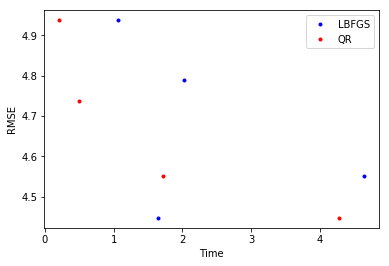

In [64]:
rmse1 = [4.9377328484633338,4.7884527758250002,4.5513680078666665,  4.4475698052266663]
time1 = [1.0644979476928711,2.025758981704712,4.634213924407959,  1.636758089065552]

rmseq = [4.9377327742385111,4.7375226333952503, 4.5513682313927744,4.4476116604281062]
time2 = [0.211525917053222, 0.4993929862976074,  1.7231628894805908, 4.27150821685791]

plt.xlabel('Time')
plt.ylabel('RMSE')
plt.plot(time1, rmse1, 'b.', label='LBFGS')
plt.plot(time2,rmseq,'r.', label='QR')
plt.legend()
plt.savefig('rmse-time.pdf', dpi=600)